In [23]:
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon, truncexpon, truncnorm, nbinom, norm
import pandas as pd
import time
import torch
from torch import nn
from torch import distributions
from torch import rand
from torch import autograd
from torch import optim

In [24]:
np.random.seed(seed=101)
torch.manual_seed(101)
torch.use_deterministic_algorithms(True)
dtype = torch.float64
device = torch.device("cpu")

In [25]:
data = pd.read_csv('covid19model.csv')

In [26]:
toy_data = pd.read_csv('toy_data.csv')
toy_data

,Unnamed: 0,0
0,0,9.319691e-16
1,1,2.800236e-02
2,2,6.963707e-02
3,3,1.213362e-01
4,4,1.795116e-01
...,...,...
402,402,4.089112e-03
403,403,3.417061e-03
404,404,2.855353e-03
405,405,2.385894e-03


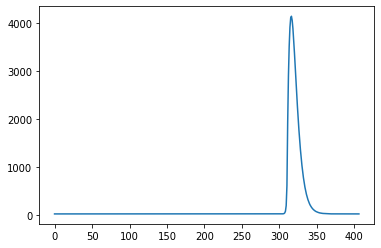

In [27]:
toy_data_np = toy_data['0'].round() + 20
plt.plot(toy_data_np)

    # Toy Data
    tau = torch.tensor(33) # bij_transform(tau_prime, lower=0, upper=200)
    y = torch.distributions.exponential.Exponential(1 / tau).rsample()
    R0 = torch.tensor(3.6) # bij_transform(R0_prime, lower=2, upper=5)
    phi = torch.tensor(25) # bij_transform(phi_prime, lower=1, upper=50)
    alpha = torch.tensor(0.01) # bij_transform(alpha_prime, lower=0, upper=0.05)
    sigma = torch.tensor(0.1) #bij_transform(sigma_prime, lower=0.0001, upper=0.5)

# Initialization

In [28]:
cero = torch.tensor(0., requires_grad=False, device=device, dtype=dtype)
num_impute = 6
observed_daily_hospit = torch.tensor(toy_data_np, requires_grad=False, device=device, dtype=dtype)
#observed_daily_hospit = torch.tensor(data.hospit, requires_grad=False, device=device, dtype=dtype)
pi = torch.tensor(data.delay_distr, requires_grad=False, device=device, dtype=dtype)
serial_interval = torch.tensor(data.serial_interval, requires_grad=False, device=device, dtype=dtype)
population = torch.tensor(5793636, requires_grad=False, device=device, dtype=dtype)
num_observations = len(observed_daily_hospit)

## Initialize latent variables/parameters

In [29]:
tau_prime = torch.tensor(np.random.exponential(1 / 0.03), requires_grad=True, device=device, dtype=dtype)
phi_prime = torch.tensor(truncnorm.rvs((0 - 25) / 10, (np.inf - 25) / 10, loc=25, scale=10), requires_grad=True,
                         device=device,
                         dtype=dtype)  # has to be positive, between 0-50 --> uniform # dispersion (shape) parameter for observations
R0_prime = torch.tensor(truncnorm.rvs((2 - 3.6) / 0.8, (5 - 3.6) / 0.8, loc=3.6, scale=0.8), requires_grad=True,
                        device=device,
                        dtype=dtype)  # probably gamma or inverse gamma distribution (compare to truncated normal) # initial reproduction number
alpha_prime = torch.tensor(
    truncnorm.rvs((0 - 1 / 100) / 1 / 100, (5 / 100 - 1 / 100) / 1 / 100, loc=1 / 100, scale=1 / 100),
    requires_grad=True, device=device,
    dtype=dtype)  # uniform distribution between (0-5%) # probability to get hospitalized
sigma_prime = torch.tensor(truncnorm.rvs((0 - 0.1) / 0.3, (0.5 - 0.1) / 0.3, loc=0.1, scale=0.3), requires_grad=True,
                           device=device,
                           dtype=dtype)  # positive, tricky, gamma or inverse gamma, log normal  --> try something out, large sigma--> prone to overfitting # standart deviation of random walk step

epsilon_t = torch.zeros(num_observations, device=device)
epsilon_t[0] = torch.distributions.Normal(cero, sigma_prime.detach()).rsample()
for t in range(1, num_observations):
    epsilon_t[t] = torch.distributions.Normal(epsilon_t[t - 1].detach(), sigma_prime.detach()).rsample()
epsilon_t.requires_grad_(True)


tensor([-0.4062, -0.6443, -0.7379, -0.5224, -1.0346, -0.8584, -0.9320, -1.0597,
        -1.2271, -2.1625, -1.9980, -1.9351, -2.5766, -2.6399, -2.8520, -2.3127,
        -2.2400, -2.1588, -1.6862, -1.7545, -2.1455, -2.1636, -2.2423, -1.9797,
        -1.7461, -1.8958, -2.0178, -1.7697, -1.1899, -1.5608, -1.2986, -0.9878,
        -1.1975, -0.8651, -1.3561, -1.3298, -1.3777, -1.6734, -1.5581, -1.3892,
        -0.9920, -1.1048, -1.2804, -1.7002, -1.6482, -1.9254, -1.9525, -1.6132,
        -1.9811, -1.7413, -1.5891, -1.5620, -1.2712, -1.5568, -1.1379, -1.0850,
        -1.0561, -0.6375, -0.5553, -0.4397, -0.1980, -0.2442, -0.0438,  0.0886,
        -0.0346,  0.0927,  0.2458, -0.2554, -0.6296, -1.1790, -1.6244, -1.6822,
        -1.5316, -1.8503, -1.9239, -2.1913, -2.6200, -2.6891, -2.6408, -2.6501,
        -2.7506, -3.0649, -3.4478, -3.4980, -4.0263, -4.1605, -4.3302, -4.1965,
        -4.3513, -4.5640, -4.2001, -4.0767, -4.0118, -4.0224, -3.5900, -3.1960,
        -3.5165, -3.0897, -2.7679, -2.05

## Init Distributions

In [8]:
dist_tau = distributions.exponential.Exponential(torch.tensor([1/0.03], device=device))

dist_phi = distributions.normal.Normal(loc=torch.tensor([25], device=device), scale=torch.tensor([10], device=device))

dist_R0 = distributions.normal.Normal(loc=torch.tensor([3.6], device=device), scale=torch.tensor([0.8], device=device))

dist_alpha = distributions.normal.Normal(loc=torch.tensor([0.01], device=device), scale=torch.tensor([0.01], device=device))

dist_sigma = distributions.normal.Normal(loc=torch.tensor([0.1], device=device), scale=torch.tensor([0.3], device=device))

# Define Forward Pass

In [9]:
def bij_transform(prime, lower, upper):
    # Recieves a value in [-inf, inf] and returns value in [low, upper]
    bij = 1 / (1 + torch.exp(-prime/upper)) # 
    scale = upper - lower
    return scale * bij + lower

def bij_transform_inf(prime):
    return torch.exp(prime)

In [10]:
def calc_prior_loss(tau, phi, R0, alpha, sigma):
    # log likelihood wrt. our prior ("regularisation")
    # ll stands for log-likelihood
    ll = torch.tensor(0.0, device=device)

    ll += dist_tau.log_prob(tau)[0]

    ll += dist_phi.log_prob(phi)[0]

    ll += dist_R0.log_prob(R0)[0]

    ll += dist_alpha.log_prob(alpha)[0]

    ll += dist_sigma.log_prob(sigma)[0]

    return ll

In [11]:
def calc_prior_loss_abs(tau, phi, R0, alpha, sigma):
    # log likelihood wrt. our prior ("regularisation")
    # ll stands for log-likelihood
    ll = torch.tensor(0.0, device=device)

    ll += (tau - (1 / 0.03)) ** 2 * 1e-1

    ll += (phi - 25) ** 2 * 1e-1

    ll += (R0 - 3.6) ** 2 * 1e3

    ll += (alpha - 0.01) ** 2 * 1e6

    ll += (sigma - 0.1) ** 2 * 1e4

    return ll

In [12]:
def seed_init_infect(y):
    # Initialize newly_infected, cumulative_infected, St
    newly_infected = torch.zeros(num_observations, device=device, dtype=dtype)  # number of newly infected
    cumulative_infected = torch.zeros(num_observations, device=device)  # cumulative number of infected

    St = torch.zeros(num_observations, device=device)  # fraction of susceptible population
    # seed initial infection / impute first num_impute days
    newly_infected[0:num_impute] = y.clone()
    cumulative_infected[0] = 0.
    cumulative_infected[1:num_impute] = torch.cumsum(newly_infected[0:num_impute - 1].clone(), dim=0)
    St[0:num_impute] = torch.tensor([torch.maximum(population.clone() - x, torch.tensor(0)) / population for x in
                                     cumulative_infected[0:num_impute].clone()])
    return newly_infected, cumulative_infected, St


In [13]:
def calc_Rt(R0, epsilon_t, sigma, ll):
    # Initialize eta_t
    eta_t = torch.zeros(num_observations, device=device)  # transformed reproduction number
    # calculate Rt: the basic reproduction number
    # basic reproduction number as a latent random walk
    beta_0 = torch.log(R0)
    eta_t[0] = beta_0

    #for t in range(1, num_observations):
    #    dist_epsilon_t = torch.distributions.Normal(epsilon_t[t - 1], sigma)
    #    ll += dist_epsilon_t.log_prob(epsilon_t[t])

    loc = epsilon_t[:-1].clone()
    scale = sigma * torch.ones(num_observations-1)
    mvn = distributions.multivariate_normal.MultivariateNormal(loc, scale_tril=torch.diag(scale))
    ll += mvn.log_prob(epsilon_t[1:].clone())

    eta_t[1:num_observations] = beta_0 + epsilon_t[0:num_observations - 1].clone()
    Rt = torch.exp(eta_t)
    return Rt, ll


In [14]:
def calc_infections(cumulative_infected, newly_infected, St, Rt):
    # Initialize effectively_infectious
    effectively_infectious = torch.zeros(num_observations, device=device)  # effective number of infectious individuals

    # calculate infections
    for t in range(num_impute, num_observations):
        # Update cumulative newly_infected
        cumulative_infected[t] = cumulative_infected[t - 1].clone() + newly_infected[t - 1].clone()
        # Adjusts for portion of pop that are susceptible
        St[t] = torch.maximum(population.clone() - cumulative_infected[t].clone(), cero) / population.clone()
        # effective number of infectous individuals
        ni_temp = newly_infected[:t].view(1, 1, -1).clone()
        si_temp = torch.flip(serial_interval, (0,))[-t:].view(1, 1, -1)
        effectively_infectious[t] = torch.nn.functional.conv1d(ni_temp, si_temp)

        newly_infected[t] = St[t].clone() * Rt[t].clone() * effectively_infectious[t].clone()
    return newly_infected


In [15]:
def calc_hospit(newly_infected, alpha):
    # Initialize expected_daily_hospit
    expected_daily_hospit = torch.zeros(num_observations, device=device)  # expected number of daily hospitalizations

    # calculate expected number of hospitalizations
    expected_daily_hospit[0] = (1e-15) * newly_infected[0].clone()
    for t in range(1, num_observations):
        ni_temp = newly_infected[:t].view(1, 1, -1)
        pi_temp = torch.flip(pi, (0,))[-t - 1:-1].view(1, 1, -1)
        expected_daily_hospit[t] = torch.nn.functional.conv1d(ni_temp, pi_temp)
    expected_daily_hospit = alpha * expected_daily_hospit
    return expected_daily_hospit


In [16]:
def compare_results(expected_daily_hospit, phi, ll):
    # compare observed hospitalizations to model results
    # likelihood of the data wrt. to the model

    for i in range(0, num_observations):
        p = 1 / (1 + expected_daily_hospit[i] / phi)
        if p == 1:
            p = p.clone() - torch.tensor(2.225e-5)
        if p < 2.225e-5:
            p = p.clone() + torch.tensor(2.225e-5)
        dist = torch.distributions.negative_binomial.NegativeBinomial(phi, p - torch.tensor(2.225e-5))
        ll += dist.log_prob(observed_daily_hospit[i])
    return ll


In [17]:
def forward_pass():
    # Initialize y
    tau = bij_transform(tau_prime, lower=0.000001, upper=200)
    y = torch.distributions.exponential.Exponential(1 / tau).rsample()
    R0 = bij_transform(R0_prime, lower=2, upper=5)
    phi = bij_transform(phi_prime, lower=0.000001, upper=50)
    alpha = bij_transform(alpha_prime, lower=0.000001, upper=0.05)
    sigma = bij_transform(sigma_prime, lower=0.000001, upper=0.5)


    # Calculate prior loss
    ll_prior = calc_prior_loss(tau, phi, R0, alpha, sigma)

    # Seed initial infections
    newly_infected, cumulative_infected, St = seed_init_infect(y)

    # Calculate Rt & random walk loss
    Rt, ll_rw = calc_Rt(R0, epsilon_t, sigma, torch.tensor(0.0, device=device)) ##ll

    # Calculate infections
    newly_infected = calc_infections(cumulative_infected, newly_infected, St, Rt)

    # Calculate expected hospitalizations
    expected_daily_hospit = calc_hospit(newly_infected, alpha)

    # Compare observed hospitalizations to model results
    ll_comp = compare_results(expected_daily_hospit, phi, torch.tensor(0.0, device=device)) ##ll

    return expected_daily_hospit, Rt, ll_prior, ll_rw, ll_comp, tau, R0, phi, alpha, sigma


# Optimization


Prior Loss:-3533.39013671875  Random Walk Loss:-70.60342407226562 Comparison Loss:-85229.2578125 


Time Step: 0 || Loss: 88833.25 || Learning Rate: 1e-05

R0:3.836154873768203  grad:-4228.669275914953
alpha:0.027492114788012043  grad:-15262.015892836916
phi:31.555405650289227  grad:513.3746657712836
sigma:0.32102158447018614  grad:63.807300637534794
epsilon_t.mean:-0.37735244631767273  grad.mean:-279.7677001953125
tau:106.04673406029183  grad:-5.799984032530638

This Run:  0.510678768157959 seconds


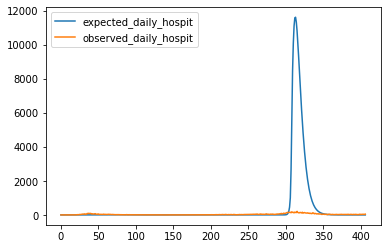

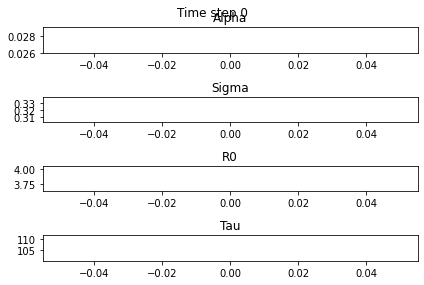


Prior Loss:-3539.6142578125  Random Walk Loss:-72.8878173828125 Comparison Loss:-94685.15625 


Time Step: 10 || Loss: 98297.65625 || Learning Rate: 9.996333962710563e-06

R0:3.8568987826140155  grad:-604.2129960897789
alpha:0.04936558457256912  grad:-283.64932827508215
phi:31.543424740358155  grad:558.7004581323553
sigma:0.3196078601657331  grad:58.422597722744754
epsilon_t.mean:-0.36763954162597656  grad.mean:-40.46625518798828
tau:106.04679706363466  grad:-1.3449409216187391

This Run:  0.42473769187927246 seconds


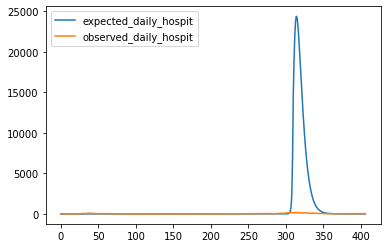


Prior Loss:-3539.734375  Random Walk Loss:-75.92758178710938 Comparison Loss:-82638.875 


Time Step: 20 || Loss: 86254.5390625 || Learning Rate: 9.986009476974643e-06

R0:3.8789501795237946  grad:-2538.6375622562837
alpha:0.04965067760549541  grad:-295.29757629202777
phi:31.531632698432446  grad:470.06455971831144
sigma:0.3183157511123669  grad:52.026618974425745
epsilon_t.mean:-0.3571039140224457  grad.mean:-172.29872131347656
tau:106.04686355426755  grad:-4.499618061899486

This Run:  0.4709055423736572 seconds


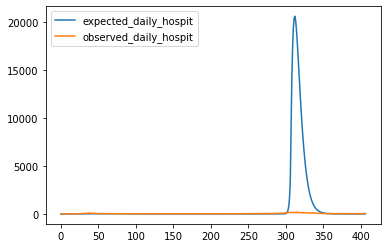


Prior Loss:-3539.805419921875  Random Walk Loss:-82.47100830078125 Comparison Loss:-67402.078125 


Time Step: 30 || Loss: 71024.3515625 || Learning Rate: 9.969046953029747e-06

R0:3.92259563032396  grad:-3662.0365767486496
alpha:0.04977607507101372  grad:-148.1653790396327
phi:31.520367615068746  grad:339.40094230105575
sigma:0.31723031384594774  grad:40.73744682114427
epsilon_t.mean:-0.3355785608291626  grad.mean:-255.58457946777344
tau:106.04698648784472  grad:-0.4542024164179561

This Run:  0.4329555034637451 seconds


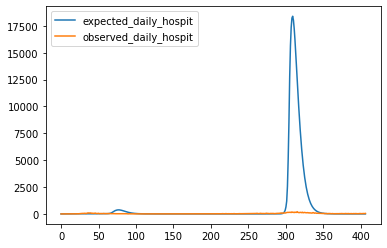


Prior Loss:-3539.858642578125  Random Walk Loss:-91.17440795898438 Comparison Loss:-77362.4609375 


Time Step: 40 || Loss: 80993.4921875 || Learning Rate: 9.945480036893252e-06

R0:3.9718804493379927  grad:-3047.9793473337677
alpha:0.04984064755722024  grad:-190.90937929155277
phi:31.51156642532099  grad:432.0872430656142
sigma:0.3164339298092163  grad:26.63159461018919
epsilon_t.mean:-0.31002405285835266  grad.mean:-220.08580017089844
tau:106.04707131873876  grad:-6.14264402497616

This Run:  0.4455373287200928 seconds


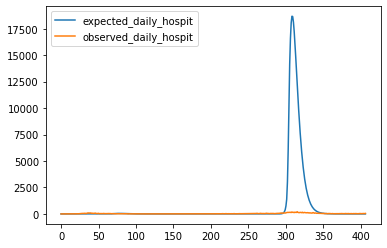


Prior Loss:-3539.901611328125  Random Walk Loss:-100.50448608398438 Comparison Loss:-75096.234375 


Time Step: 50 || Loss: 78736.640625 || Learning Rate: 9.915355499156789e-06

R0:4.015638740901888  grad:-4410.297032580554
alpha:0.04987877683388341  grad:-153.28160862429348
phi:31.503463099721426  grad:415.01312181841257
sigma:0.31597062589460706  grad:12.084880556141947
epsilon_t.mean:-0.28605279326438904  grad.mean:-328.97320556640625
tau:106.04714845945736  grad:-8.096334806375468

This Run:  0.42861318588256836 seconds


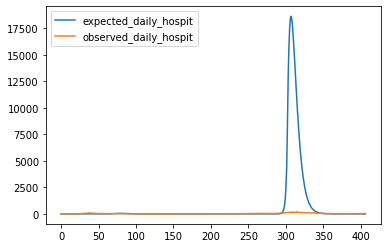

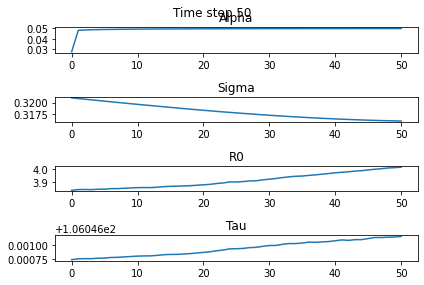


Prior Loss:-3539.93115234375  Random Walk Loss:-108.1700439453125 Comparison Loss:-57649.125 


Time Step: 60 || Loss: 61297.2265625 || Learning Rate: 9.878733080315706e-06

R0:4.0509915491549435  grad:-3001.860860738166
alpha:0.04989957602951378  grad:-79.92902036629623
phi:31.496399420780946  grad:269.5894845724031
sigma:0.3158267073398663  grad:0.527041335112972
epsilon_t.mean:-0.26568424701690674  grad.mean:-230.26504516601562
tau:106.04709264853767  grad:1.6975593090261967

This Run:  0.4490518569946289 seconds


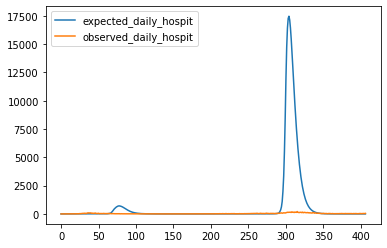


Prior Loss:-3539.963134765625  Random Walk Loss:-117.75424194335938 Comparison Loss:-54373.96875 


Time Step: 70 || Loss: 58031.6875 || Learning Rate: 9.835685293349645e-06

R0:4.087625959169607  grad:-720.5597955666949
alpha:0.0499136247116098  grad:-51.82508987669206
phi:31.490171761736782  grad:237.78212903731458
sigma:0.3159683660690628  grad:-13.315059886452321
epsilon_t.mean:-0.24349388480186462  grad.mean:-56.99945831298828
tau:106.04708251078064  grad:13.23729068573672

This Run:  0.4233839511871338 seconds


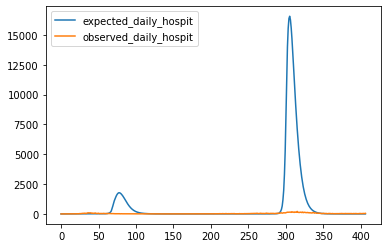


Prior Loss:-3539.96142578125  Random Walk Loss:-118.28329467773438 Comparison Loss:-52084.57421875 


Time Step: 80 || Loss: 55742.8203125 || Learning Rate: 9.786297184467404e-06

R0:4.094859604279195  grad:-2312.7182438010213
alpha:0.04992092656290254  grad:-37.56946545234965
phi:31.484621299175235  grad:224.49887752374755
sigma:0.31626536952977796  grad:-13.5092888888337
epsilon_t.mean:-0.23897646367549896  grad.mean:-184.0797882080078
tau:106.04676236816098  grad:0.8651524783892468

This Run:  0.4225881099700928 seconds


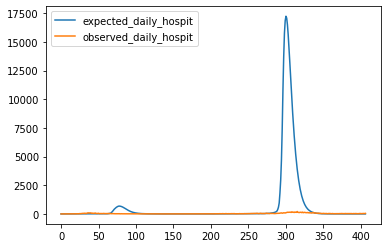


Prior Loss:-3539.97900390625  Random Walk Loss:-124.9296875 Comparison Loss:-49573.48828125 


Time Step: 90 || Loss: 53238.3984375 || Learning Rate: 9.730666053121075e-06

R0:4.1172707415266  grad:-50.152772657267484
alpha:0.049926888201340336  grad:-20.967326158698388
phi:31.479140909163522  grad:196.75212649593766
sigma:0.31667316036809096  grad:-22.458065812205025
epsilon_t.mean:-0.22464647889137268  grad.mean:-4.080080032348633
tau:106.04667058075627  grad:16.885636134774195

This Run:  0.4265103340148926 seconds


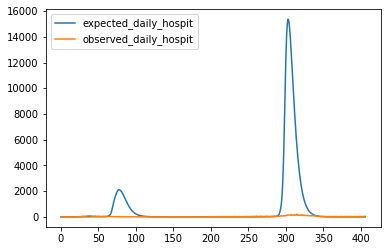


Prior Loss:-3539.98779296875  Random Walk Loss:-129.34786987304688 Comparison Loss:-47967.41796875 


Time Step: 100 || Loss: 51636.75390625 || Learning Rate: 9.668901132579719e-06

R0:4.13204491461266  grad:-1464.3064173644877
alpha:0.04992966618775122  grad:-0.44993011160990726
phi:31.474328609217938  grad:182.6129571466121
sigma:0.3172069590386549  grad:-27.851147574187
epsilon_t.mean:-0.21492615342140198  grad.mean:-120.51210021972656
tau:106.04651201917758  grad:2.7781456127036854

This Run:  0.42873716354370117 seconds


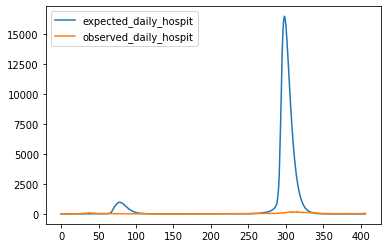

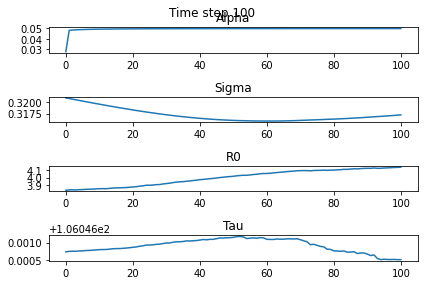


Prior Loss:-3540.001708984375  Random Walk Loss:-135.35906982421875 Comparison Loss:-46228.390625 


Time Step: 110 || Loss: 49903.75 || Learning Rate: 9.601123232530429e-06

R0:4.149863461614193  grad:-103.8564367926875
alpha:0.0499331236654736  grad:3.340727134535406
phi:31.468916719449638  grad:165.67630594960352
sigma:0.31786867929498014  grad:-35.27345397457693
epsilon_t.mean:-0.2028946727514267  grad.mean:-8.699654579162598
tau:106.0464025516507  grad:13.48484048641799

This Run:  0.4302701950073242 seconds


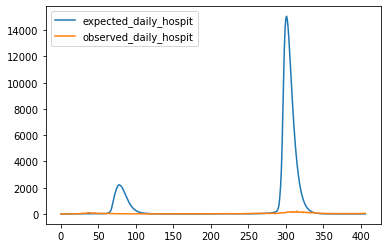


Prior Loss:-3540.00244140625  Random Walk Loss:-137.85479736328125 Comparison Loss:-50075.55859375 


Time Step: 120 || Loss: 53753.4140625 || Learning Rate: 9.527464345343567e-06

R0:4.1570406643424445  grad:-1677.3929330505355
alpha:0.04993153454376375  grad:3.4532637249020834
phi:31.46525968637499  grad:200.14713834674913
sigma:0.31866183785269125  grad:-37.26915676685634
epsilon_t.mean:-0.19793802499771118  grad.mean:-141.34429931640625
tau:106.04620342450522  grad:-1.3358308556766822

This Run:  0.43143177032470703 seconds


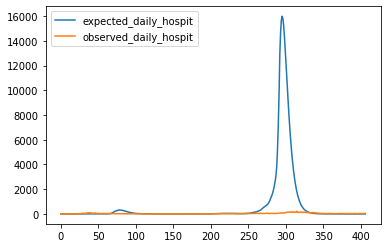


Prior Loss:-3540.0078125  Random Walk Loss:-141.18539428710938 Comparison Loss:-47636.45703125 


Time Step: 130 || Loss: 51317.6484375 || Learning Rate: 9.44806721779826e-06

R0:4.166306243453887  grad:2424.4940210364935
alpha:0.04993132785442327  grad:-9.036818590233343
phi:31.46075257817763  grad:178.2572751941625
sigma:0.3195571994981586  grad:-40.24470073825274
epsilon_t.mean:-0.1914718747138977  grad.mean:206.12167358398438
tau:106.04607722394671  grad:32.30218374358188

This Run:  0.4215250015258789 seconds


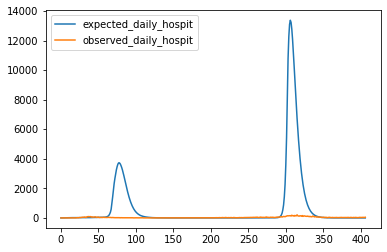


Prior Loss:-3540.015380859375  Random Walk Loss:-144.68975830078125 Comparison Loss:-45025.75 


Time Step: 140 || Loss: 48710.453125 || Learning Rate: 9.363084890213e-06

R0:4.176479591260721  grad:-884.0731070162981
alpha:0.04992913009967808  grad:41.61205123773674
phi:31.456810395319014  grad:144.78514998354888
sigma:0.32044231901352316  grad:-43.464055765496376
epsilon_t.mean:-0.18423344194889069  grad.mean:-75.93102264404297
tau:106.04599614338363  grad:2.4933529326395503

This Run:  0.44178223609924316 seconds


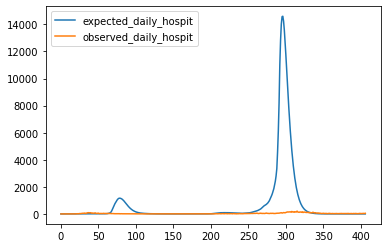


Prior Loss:-3540.012451171875  Random Walk Loss:-145.79867553710938 Comparison Loss:-43295.953125 


Time Step: 150 || Loss: 46981.765625 || Learning Rate: 9.272680205063641e-06

R0:4.179251664857437  grad:-582.9170908011567
alpha:0.049926457072086664  grad:51.9048647559496
phi:31.453167226247402  grad:127.46380716967293
sigma:0.3213798521215498  grad:-43.12295409081389
epsilon_t.mean:-0.18224547803401947  grad.mean:-50.20710754394531
tau:106.04579142503539  grad:5.382281775657632

This Run:  0.4328486919403076 seconds


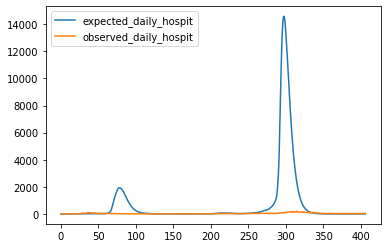

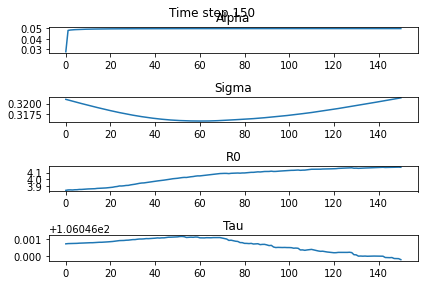


Prior Loss:-3540.01806640625  Random Walk Loss:-149.49783325195312 Comparison Loss:-42870.4140625 


Time Step: 160 || Loss: 46559.9296875 || Learning Rate: 9.177025287296339e-06

R0:4.188738595028939  grad:-290.1683493319981
alpha:0.04992163523818709  grad:48.85118193693696
phi:31.449763021701504  grad:126.76754254479785
sigma:0.32231732707954036  grad:-46.46953729541709
epsilon_t.mean:-0.17534075677394867  grad.mean:-25.237035751342773
tau:106.04570620094319  grad:8.208562395709855

This Run:  0.4207923412322998 seconds


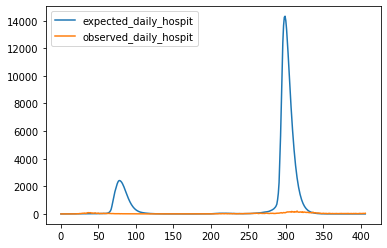


Prior Loss:-3540.02197265625  Random Walk Loss:-152.66122436523438 Comparison Loss:-51407.6640625 


Time Step: 170 || Loss: 55100.34765625 || Learning Rate: 9.076300998655633e-06

R0:4.196535889798307  grad:4453.7929570063
alpha:0.04991365256338532  grad:-30.403058871577606
phi:31.44681954990494  grad:222.79483081042716
sigma:0.32330851178923864  grad:-48.91576759234598
epsilon_t.mean:-0.16957563161849976  grad.mean:390.3034362792969
tau:106.04562001116894  grad:44.05429005956567

This Run:  0.5556979179382324 seconds


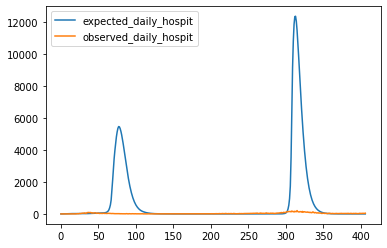


Prior Loss:-3540.010986328125  Random Walk Loss:-152.37518310546875 Comparison Loss:-44971.19921875 


Time Step: 180 || Loss: 48663.5859375 || Learning Rate: 8.97069636844711e-06

R0:4.194642212620723  grad:-979.7205910004286
alpha:0.04990610355546631  grad:62.746372540232805
phi:31.44370119234516  grad:143.33781382328257
sigma:0.3242568007224386  grad:-46.57514624037516
epsilon_t.mean:-0.17099614441394806  grad.mean:-85.70179748535156
tau:106.04537167551248  grad:1.5902708881968082

This Run:  0.4197371006011963 seconds


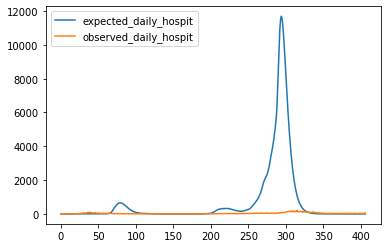


Prior Loss:-3540.011474609375  Random Walk Loss:-155.2252197265625 Comparison Loss:-41758.09765625 


Time Step: 190 || Loss: 45453.3359375 || Learning Rate: 8.860408003239587e-06

R0:4.20122288620931  grad:-448.5322211436834
alpha:0.04989567545274813  grad:92.4764409122164
phi:31.44067254120288  grad:111.42427274962158
sigma:0.325206383367465  grad:-48.64447379109729
epsilon_t.mean:-0.16608776152133942  grad.mean:-39.507835388183594
tau:106.04526337527507  grad:5.747697046389639

This Run:  0.4331629276275635 seconds


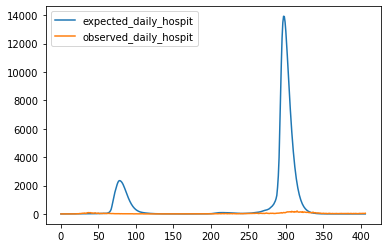


Prior Loss:-3540.005859375  Random Walk Loss:-157.16888427734375 Comparison Loss:-41500.03515625 


Time Step: 200 || Loss: 45197.2109375 || Learning Rate: 8.745639478083047e-06

R0:4.205099443389607  grad:-495.27056956031686
alpha:0.04987862448747871  grad:116.25382882691369
phi:31.43814923744332  grad:107.58552637401796
sigma:0.32619413814935866  grad:-49.355910171743304
epsilon_t.mean:-0.1631665825843811  grad.mean:-43.799739837646484
tau:106.04512103571354  grad:5.005142296288514

This Run:  0.4343080520629883 seconds


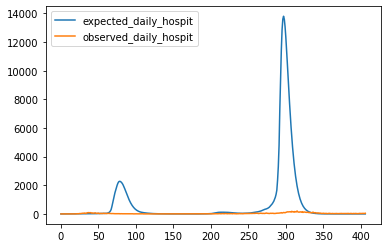

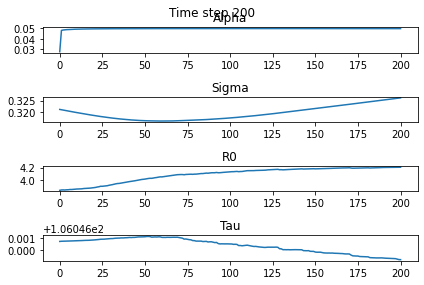


Prior Loss:-3540.003173828125  Random Walk Loss:-160.38430786132812 Comparison Loss:-44891.01953125 


Time Step: 210 || Loss: 48591.40625 || Learning Rate: 8.626600711875584e-06

R0:4.212349886725655  grad:-980.6294408826398
alpha:0.04985445107683423  grad:96.91958437896763
phi:31.435563934983744  grad:143.5640822921679
sigma:0.32718698866198365  grad:-51.809338742060355
epsilon_t.mean:-0.1576453298330307  grad.mean:-87.37521362304688
tau:106.04504858816502  grad:1.3385764735790118

This Run:  0.45325517654418945 seconds


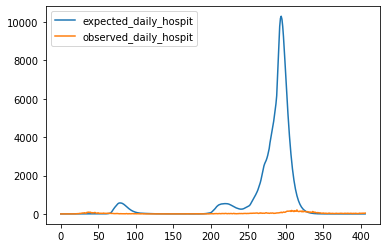


Prior Loss:-3539.987060546875  Random Walk Loss:-161.36138916015625 Comparison Loss:-47257.984375 


Time Step: 220 || Loss: 50959.33203125 || Learning Rate: 8.503507329554794e-06

R0:4.213182230995052  grad:-1280.1138915961224
alpha:0.04982191552198659  grad:73.75613051628571
phi:31.43300895278813  grad:171.33320331135542
sigma:0.32818156074067134  grad:-51.156029674458146
epsilon_t.mean:-0.15701624751091003  grad.mean:-114.15687561035156
tau:106.04486928531486  grad:-0.42316871473600265

This Run:  0.42812180519104004 seconds


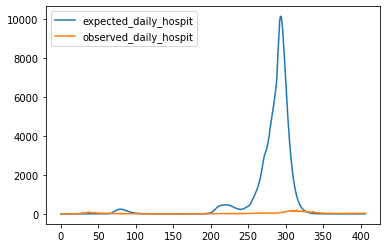


Prior Loss:-3539.97314453125  Random Walk Loss:-162.76763916015625 Comparison Loss:-43024.76171875 


Time Step: 230 || Loss: 46727.50390625 || Learning Rate: 8.37658001381676e-06

R0:4.214277624714212  grad:-829.9251450511607
alpha:0.04979431733488551  grad:174.95867432170556
phi:31.429852379970416  grad:122.98591635526684
sigma:0.32916284789908345  grad:-51.12496012797534
epsilon_t.mean:-0.15619662404060364  grad.mean:-74.09961700439453
tau:106.04467916538772  grad:2.3480664132893816

This Run:  0.42496466636657715 seconds


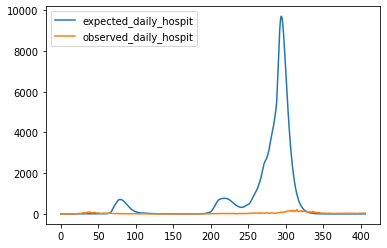


Prior Loss:-3539.94091796875  Random Walk Loss:-165.325927734375 Comparison Loss:-41628.44140625 


Time Step: 240 || Loss: 45333.70703125 || Learning Rate: 8.246043849078613e-06

R0:4.219189832252556  grad:-630.3611819811404
alpha:0.049704696432594765  grad:308.696750350873
phi:31.42761669642876  grad:106.28092520011259
sigma:0.3301284681116189  grad:-52.69250266076254
epsilon_t.mean:-0.15240024030208588  grad.mean:-56.57863235473633
tau:106.0445745517354  grad:3.668845561610881

This Run:  0.4316272735595703 seconds


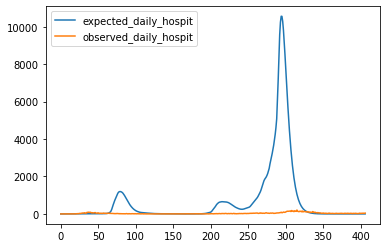


Prior Loss:-3539.860595703125  Random Walk Loss:-167.5765380859375 Comparison Loss:-41178.34765625 


Time Step: 250 || Loss: 44885.78515625 || Learning Rate: 8.112127660399214e-06

R0:4.222711165846871  grad:-587.8374791057731
alpha:0.04949670246640505  grad:552.6519971173195
phi:31.42542793908775  grad:101.53600054292394
sigma:0.33111039755772004  grad:-53.7956354742594
epsilon_t.mean:-0.14965733885765076  grad.mean:-52.96181869506836
tau:106.0444460110469  grad:3.932450199646508

This Run:  0.44074440002441406 seconds


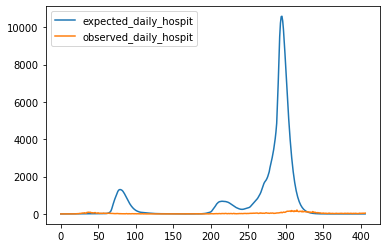

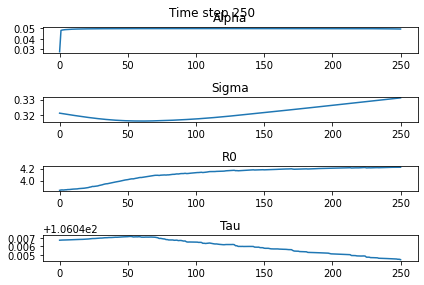


Prior Loss:-3539.5263671875  Random Walk Loss:-171.3902587890625 Comparison Loss:-41385.1953125 


Time Step: 260 || Loss: 45096.11328125 || Learning Rate: 7.975063350056372e-06

R0:4.230265532059385  grad:-633.4699890694638
alpha:0.048621907169135274  grad:1418.879231181232
phi:31.42304888520534  grad:106.3194166489183
sigma:0.3321035801205287  grad:-56.96402279096562
epsilon_t.mean:-0.143708735704422  grad.mean:-57.540061950683594
tau:106.04439427819709  grad:3.4788895880098782

This Run:  0.422046422958374 seconds


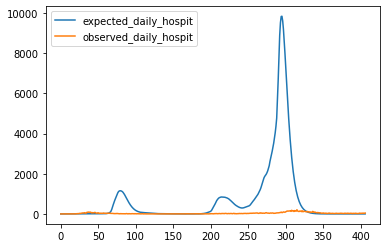


Prior Loss:-3532.384765625  Random Walk Loss:-173.42340087890625 Comparison Loss:-38443.46875 


Time Step: 270 || Loss: 42149.27734375 || Learning Rate: 7.83508523444914e-06

R0:4.2322381326274545  grad:-703.0987664536053
alpha:0.017959397724200212  grad:10648.342760081423
phi:31.420419229424375  grad:156.13527607282194
sigma:0.3331058888866121  grad:-57.7006825689255
epsilon_t.mean:-0.14215627312660217  grad.mean:-64.00088500976562
tau:106.0442491734845  grad:3.611551112920691

This Run:  0.43588757514953613 seconds


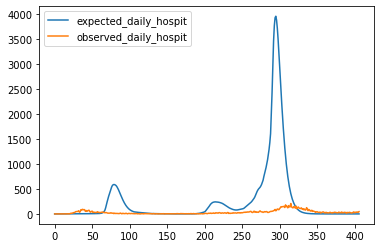


Prior Loss:-3540.01416015625  Random Walk Loss:-174.876953125 Comparison Loss:-39133.71875 


Time Step: 280 || Loss: 42848.609375 || Learning Rate: 7.692429383950039e-06

R0:4.232007890356217  grad:-439.4580466475312
alpha:0.04987536184344193  grad:166.06856400385888
phi:31.41798232292471  grad:80.1977348577471
sigma:0.3341124299691277  grad:-57.65188505191327
epsilon_t.mean:-0.14235062897205353  grad.mean:-39.99629592895508
tau:106.04406759683656  grad:5.040414992466555

This Run:  0.4306373596191406 seconds


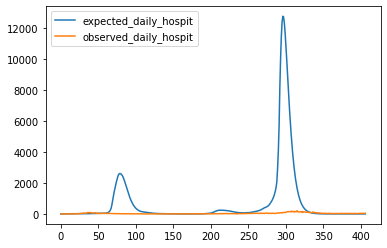


Prior Loss:-3540.009521484375  Random Walk Loss:-178.376708984375 Comparison Loss:-42498.96484375 


Time Step: 290 || Loss: 46217.3515625 || Learning Rate: 7.547332968275264e-06

R0:4.2383666731025365  grad:-903.1242783734282
alpha:0.049846255621368324  grad:134.67055940049735
phi:31.416005339831802  grad:117.75131763920592
sigma:0.33510419794214286  grad:-60.33236734157131
epsilon_t.mean:-0.13725753128528595  grad.mean:-82.75995635986328
tau:106.04401050279833  grad:1.7944266982492325

This Run:  0.4285273551940918 seconds


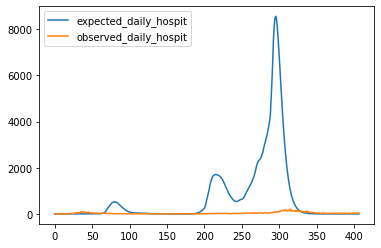

Complete Run:  140.53377437591553 seconds


In [18]:
# Visualization initialization
alpha_vis = []
sigma_vis = []
R0_vis = []
tau_vis = []
phi_vis = []
epsilon_mean_vis = []
loss_vis = []
prior_loss_vis = []
rw_loss_vis = []
comp_loss_vis = []
learning_rate_vis = []

learning_rate = 1e-5
epochs = 300
complete_time = time.time()


for k in range(epochs):
    start_time = time.time()
    decay = (1 - (k / (epochs * 1000))) ** 2
    learning_rate = learning_rate * decay

    # forward pass - calculate expected_daily_hospit
    expected_daily_hospit, Rt, ll_prior, ll_rw, ll_comp, tau, R0, phi, alpha, sigma = forward_pass()

    # backward pass
    loss = -(ll_prior + ll_rw + ll_comp)
    loss.backward()

    if k % 10 == 0:
        print(
            f'\nPrior Loss:{ll_prior}  Random Walk Loss:{ll_rw} Comparison Loss:{ll_comp} \n'
            f'\n\nTime Step: {k} || Loss: {loss} || Learning Rate: {learning_rate}\n\nR0:{R0}  grad:{R0_prime.grad}\nalpha:{alpha}  grad:{alpha_prime.grad}\n'
            f'phi:{phi}  grad:{phi_prime.grad}\nsigma:{sigma}  grad:{sigma_prime.grad}'
            f'\nepsilon_t.mean:{epsilon_t.mean()}  grad.mean:{epsilon_t.grad.mean()}\ntau:{tau}  grad:{tau_prime.grad}\n')
        print("This Run:  %s seconds" % (time.time() - start_time))
    

    
    with torch.no_grad():  # this part is SGD. can also replace with loss.step
        tau_prime -= learning_rate * tau_prime.grad
        phi_prime -= learning_rate * phi_prime.grad
        R0_prime -= learning_rate * R0_prime.grad
        alpha_prime -= learning_rate * alpha_prime.grad
        sigma_prime -= learning_rate * sigma_prime.grad
        epsilon_t -= learning_rate * epsilon_t.grad

        tau_prime.grad = None
        phi_prime.grad = None
        R0_prime.grad = None
        alpha_prime.grad = None
        sigma_prime.grad = None
        epsilon_t.grad = None


    # Visualization
    alpha_vis.append(alpha)
    sigma_vis.append(sigma)
    R0_vis.append(R0)
    tau_vis.append(tau)
    phi_vis.append(phi)
    epsilon_mean_vis.append(epsilon_t.abs().mean())
    loss_vis.append(loss)
    prior_loss_vis.append(ll_prior)
    rw_loss_vis.append(ll_rw)
    comp_loss_vis.append(ll_comp)
    learning_rate_vis.append(learning_rate)

    if k % 10 == 0:
        plt.plot(expected_daily_hospit.cpu().detach().numpy(), label='expected_daily_hospit')
        plt.plot(observed_daily_hospit.cpu().detach().numpy(), label='observed_daily_hospit')
        plt.legend()
        plt.show()

    if k % 50 == 0:
        fig, axs = plt.subplots(4)
        fig.suptitle(f'Time step {k}')
        axs[0].plot(alpha_vis)
        axs[0].title.set_text('Alpha')
        axs[1].plot(sigma_vis)
        axs[1].title.set_text('Sigma')
        axs[2].plot(R0_vis)
        axs[2].title.set_text('R0')
        axs[3].plot(tau_vis)
        axs[3].title.set_text('Tau')
        fig.tight_layout()
        plt.show()


print("Complete Run:  %s seconds" % (time.time() - complete_time))

# Evaluate Model

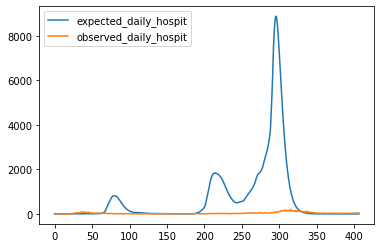

In [19]:
plt.plot(expected_daily_hospit.cpu().detach().numpy(), label='expected_daily_hospit')
plt.plot(observed_daily_hospit.cpu().detach().numpy(), label='observed_daily_hospit')
plt.legend()
plt.show()

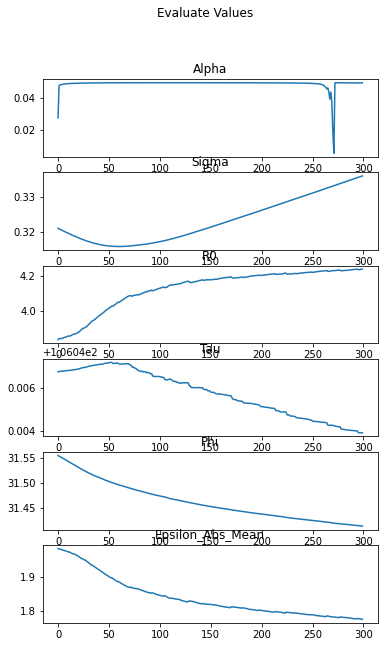

In [20]:
fig, axs = plt.subplots(6)
fig.suptitle(f'Evaluate Values')
fig.set_figheight(10)
axs[0].plot(alpha_vis)
axs[0].title.set_text('Alpha')
axs[1].plot(sigma_vis)
axs[1].title.set_text('Sigma')
axs[2].plot(R0_vis)
axs[2].title.set_text('R0')
axs[3].plot(tau_vis)
axs[3].title.set_text('Tau')
axs[4].plot(phi_vis)
axs[4].title.set_text('Phi')
axs[5].plot(epsilon_mean_vis)
axs[5].title.set_text('Epsilon_Abs_Mean')
plt.show()

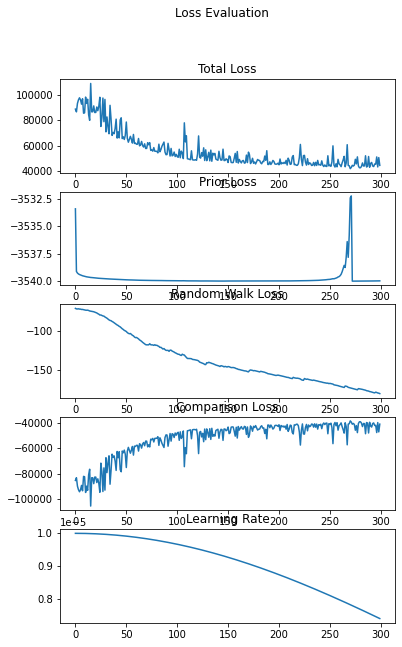

In [21]:
fig, axs = plt.subplots(5)
fig.suptitle(f'Loss Evaluation')
fig.set_figheight(10)
axs[0].plot(loss_vis)
axs[0].title.set_text('Total Loss')
axs[1].plot(prior_loss_vis)
axs[1].title.set_text('Prior Loss')
axs[2].plot(rw_loss_vis)
axs[2].title.set_text('Random Walk Loss')
axs[3].plot(comp_loss_vis)
axs[3].title.set_text('Comparison Loss')
axs[4].plot(learning_rate_vis)
axs[4].title.set_text('Learning Rate')
plt.show()

In [22]:
break

SyntaxError: ignored

In [ ]:
phi_tensor_prime = torch.tensor(35.0, requires_grad=True, device=device, dtype=dtype)

In [ ]:
#exp_daily = torch.tensor(20)
obs_daily = torch.tensor(20)


phi_tensor_prime = torch.tensor(1.0, requires_grad=True, device=device, dtype=dtype)
learning_rate = 0.01
phi_vis = []

for i in range(100):
  # forward pass
  ll = torch.tensor(0.0)
  phi_tensor = bij_transform(phi_tensor_prime, 0, 50)
  for exp_daily in np.linspace(1, 100):
    exp_daily_tensor = torch.tensor(exp_daily)
    p = 1 / (1 + exp_daily_tensor / phi_tensor)
    if p == 1:
        p = p.clone() - torch.tensor(2.225e-5)
    if p < 2.225e-5:
        p = p.clone() + torch.tensor(2.225e-5)
    dist = torch.distributions.negative_binomial.NegativeBinomial(phi_tensor, p)
    ll += dist.log_prob(obs_daily)

  ll.backward()
  if i%10==0: print(f'phi: {phi_tensor}, grad: {phi_tensor_prime.grad}')
  
  with torch.no_grad():  # this part is SGD. can also replace with loss.step
        phi_tensor_prime -= learning_rate * phi_tensor_prime.grad
        phi_tensor_prime.grad = None
  
  phi_vis.append(phi_tensor.item())

print(f'loss: {ll}')
plt.plot(phi_vis)
plt.show()

In [ ]:
#phi_tensor_prime = torch.tensor(35.0, requires_grad=True, device=device, dtype=dtype)
#phi_tensor = bij_transform_inf(phi_tensor_prime)
phi_vis =[]
phi_prime_vis=[]
upper = 50
for i in np.linspace(-upper*5, upper*5):
  phi_tensor_prime = torch.tensor(i)
  phi_tensor = bij_transform(phi_tensor_prime, 0, upper)
  phi_vis.append(phi_tensor.item())


plt.plot(phi_vis, label='Phi')
plt.legend()
plt.show()

In [ ]:
ll = torch.tensor(0.)

In [ ]:
dist_phi = distributions.normal.Normal(loc=torch.tensor([25], device=device), scale=torch.tensor([10], device=device))

In [ ]:
#dist_phi = distribution.normal.Normal(loc=torch.tensor([25]), scale=torch.tensor([10]))
ll += dist_phi.log_prob(phi)[0]

In [ ]:
dist_phi.log_prob(phi)[0]

In [ ]:
dist_phi.log_prob(phi)